# Heston Model Calibration on Crypto-currencies Option's 

## Heston's Stochastic Volatility Model under real world probability measure

$\large dS_t = \mu S_t dt + \sqrt{v_t} S_t dW^\mathbb{P}_{1,t}$

$\large dv_t = \kappa (\theta - v_t)dt + \sigma \sqrt{v_t} dW^\mathbb{P}_{2,t}$

$\large \rho dt = dW^\mathbb{P}_{2,t} dW^\mathbb{P}_{2,t} $


Notation:
- $S_t$ Equity spot price, financial index
- $v_t$ Variance.
- $C$ European call option price.
- $K$ Strike price.
- $W_{1,2}$ Standard Brownian movements.
- $r$ Interest rate.
- $\kappa$ Mean reversion rate.
- $\theta$ Long run variance.
- $v_0$ Initial variance.
- $\sigma$ Volatility of variance.
- $\rho$ Correlation parameter.
- $t$ Current date.
- $T$ Maturity date.

In [54]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from math import pow, sqrt

from scipy.integrate import quad
from scipy.optimize import minimize, root
from datetime import datetime as dt
from scipy.stats import norm

from eod import EodHistoricalData
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

import QuantLib as ql
from QuantLib import Constraint, CompositeConstraint, PositiveConstraint, NoConstraint

pd.set_option('display.max_columns', 100)

### Risk-free rate from US Daily Treasury Par Yield Curve Rates

https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics?data=yield%27

Parametric Model: Let’s explore a parametric model for arriving at ZC and implied forward rates.

Learn about using a parametric model for stripping a yield curve with Nelson Siegel Svensson model here: https://abhyankar-ameya.medium.com/yield-curve-analytics-with-python-e9254516831c

In [55]:
yield_maturities = np.array([1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
yeilds = np.array([5.50, 5.47, 5.46, 5.41, 5.14, 4.83, 4.60, 4.44, 4.43, 4.42, 4.66, 4.56]).astype(float)/100

**Nelson Siegel Svensson model using ordinary least squares approach**

In [56]:
import matplotlib.pyplot as plt
#NSS model calibrate
curve_fit, status = calibrate_nss_ols(yield_maturities,yeilds)

curve_fit

NelsonSiegelSvenssonCurve(beta0=0.04813758202467356, beta1=0.007922595248649179, beta2=-0.013896838190877347, beta3=-0.008891471454150587, tau1=2.0, tau2=5.0)

**Cubic Spline approach**

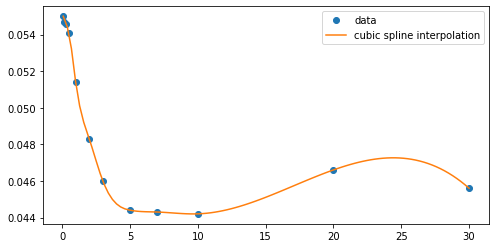

In [57]:
from scipy.interpolate import CubicSpline

cs = CubicSpline(yield_maturities, yeilds)


# Interpolated values at specific points
x_new = np.linspace(1/12, 30, 100)
y_new = cs(x_new)

# Optionally, you can plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(yield_maturities, yeilds, 'o', label='data')
plt.plot(x_new, y_new, label='cubic spline interpolation')
plt.legend()
plt.show()

## Black Scholes Pricer

In [58]:
N = norm.cdf

def bs_call(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan  # Return NaN for invalid inputs
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T) * N(d2)

def bs_put(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan  # Return NaN for invalid inputs
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T) * N(-d2) - S * N(-d1)

## BTC and ETH Option Data DERIVIT API

#### Get Market Option Prices for BTC and ETH

In [59]:
# This is the script we ued for scfraping Deribit option data on btc and eth

df_btc = pd.read_csv("C:/Users/wangd/OneDrive - Università Commerciale Luigi Bocconi/Desktop/Data/btc_options.csv")
df_eth = pd.read_csv("C:/Users/wangd/OneDrive - Università Commerciale Luigi Bocconi/Desktop/Data/eth_options.csv")
df = df_eth

In [60]:
df["price"]= df["index_price"] * df["mark_price"]
df["mark_iv"]= df["mark_iv"]/100

# Convert maturity to numeric if it's in datetime format
df['maturity'] = pd.to_datetime(df['maturity'])
# Calculate the fraction of the year until maturity
df['year_fraction'] = (df['maturity'] - pd.Timestamp('today')).dt.days / 365
# Calculate the risk free rate for each maturity using the fitted yield curve
df['rf_rate'] = df['year_fraction'].apply(cs)

In [61]:
df['bs_price'] = df.apply(
    lambda x: bs_call(x['index_price'], x['strike'], x['year_fraction'], x['rf_rate'], x['mark_iv']) 
    if x['option_type'] == 'call' else 
    bs_put(x['index_price'], x['strike'], x['year_fraction'], x['rf_rate'], x['mark_iv']),
    axis=1)
df = df.dropna()
df[250:]

,option_type,strike,creation,maturity,mark_price,last_price,mark_iv,index_price,price,year_fraction,rf_rate,bs_price
317,put,2800.00000,2023-09-27 08:01:00,2024-09-27 08:00:00,0.05140,0.03700,0.73550,3728.19000,191.62897,0.33425,0.05450,186.83874
318,call,2900.00000,2024-01-10 23:45:00,2024-09-27 08:00:00,0.29720,0.30800,0.73550,3728.19000,1108.01807,0.33425,0.05450,1099.00327
319,put,2900.00000,2024-01-10 23:45:00,2024-09-27 08:00:00,0.05990,0.04350,0.73550,3728.19000,223.31858,0.33425,0.05450,218.46516
320,call,3000.00000,2023-09-27 08:01:00,2024-09-27 08:00:00,0.28030,0.29600,0.73550,3728.19000,1045.01166,0.33425,0.05450,1035.34056
321,put,3000.00000,2023-09-27 08:01:00,2024-09-27 08:00:00,0.06930,0.05050,0.73560,3728.17000,258.36218,0.33425,0.05450,253.06588
...,...,...,...,...,...,...,...,...,...,...,...,...
497,call,11000.00000,2024-03-27 08:01:00,2025-03-28 08:00:00,0.07130,0.05700,0.92990,3729.07000,265.88269,0.83288,0.05238,267.60657
498,put,11000.00000,2024-03-27 08:01:00,2025-03-28 08:00:00,1.93350,2.24550,0.92880,3729.04000,7210.09884,0.83288,0.05238,7067.94724
499,call,12000.00000,2024-03-27 08:01:00,2025-03-28 08:00:00,0.05970,0.04850,0.92880,3729.04000,222.62369,0.83288,0.05238,223.84006
500,put,12000.00000,2024-03-27 08:01:00,2025-03-28 08:00:00,2.18240,4.10750,0.92880,3729.04000,8138.25690,0.83288,0.05238,7982.58722


In [62]:
# Analyze the range and count of strikes and maturities in descending order
strike_counts = df['strike'].value_counts().sort_values(ascending=False)
print("Strike counts in descending order:")
print(strike_counts.head(10))

Strike counts in descending order:
3600.00000    15
3300.00000    15
3200.00000    15
4400.00000    14
4200.00000    14
3900.00000    14
3800.00000    14
3700.00000    14
4600.00000    14
3000.00000    14
Name: strike, dtype: int64


In [63]:
# Define the strike range based on observed data density
'''min_strike = 2500
max_strike = 6000'''

min_strike = 2500
max_strike = 6000

df = df[(df['strike'] >= min_strike) & (df['strike'] <= max_strike) & 
                 (df['year_fraction'] > 0.02) & (df['year_fraction'] < 1)]
df

,option_type,strike,creation,maturity,mark_price,last_price,mark_iv,index_price,price,year_fraction,rf_rate,bs_price
118,call,2600.00000,2024-05-09 08:01:00,2024-06-07 08:00:00,0.30850,0.31400,0.73650,3727.53000,1149.94301,0.02740,0.05543,1131.63775
119,put,2600.00000,2024-05-09 08:01:00,2024-06-07 08:00:00,0.00020,0.00320,0.73680,3727.53000,0.74551,0.02740,0.05543,0.16299
120,call,2700.00000,2024-05-09 08:01:00,2024-06-07 08:00:00,0.28210,0.28850,0.73630,3727.49000,1051.52493,0.02740,0.05543,1032.05526
121,put,2700.00000,2024-05-09 08:01:00,2024-06-07 08:00:00,0.00040,0.00120,0.73630,3727.49000,1.49100,0.02740,0.05543,0.46799
122,call,2800.00000,2024-05-09 08:01:00,2024-06-07 08:00:00,0.25590,0.22500,0.73650,3727.49000,953.86469,0.02740,0.05543,932.94600
...,...,...,...,...,...,...,...,...,...,...,...,...
484,put,4800.00000,2024-03-27 08:01:00,2025-03-28 08:00:00,0.44220,0.61700,0.74950,3728.96000,1648.94611,0.83288,0.05238,1596.38973
485,call,5000.00000,2024-03-27 08:01:00,2025-03-28 08:00:00,0.18920,0.20900,0.77330,3728.96000,705.51923,0.83288,0.05238,714.84908
486,put,5000.00000,2024-03-27 08:01:00,2025-03-28 08:00:00,0.49030,0.60850,0.77330,3728.96000,1828.30909,0.83288,0.05238,1772.46706
487,call,6000.00000,2024-03-27 08:01:00,2025-03-28 08:00:00,0.16290,0.15850,0.84270,3728.97000,607.44921,0.83288,0.05238,614.26010


## Volatility Surface

In [64]:
import pandas as pd
import numpy as np

# Assuming 'df' is your DataFrame
volatility_surface = df.pivot_table(
    index='year_fraction',  # Maturity as index
    columns='strike',  # Strike price as columns
    values='mark_iv',  # Volatility as values
    aggfunc=np.mean  # Aggregation function, taking mean if multiple values exist
)

# Convert index and columns to numeric if they're not already
volatility_surface.index = pd.to_numeric(volatility_surface.index, errors='coerce')
volatility_surface.columns = pd.to_numeric(volatility_surface.columns, errors='coerce')

# Fill missing values at the boundaries
volatility_surface.iloc[0].fillna(method='bfill', inplace=True)  # Forward fill the first row
volatility_surface.iloc[-1].fillna(method='ffill', inplace=True)  # Backward fill the last row
volatility_surface.fillna(method='ffill', axis=0, inplace=True)  # Forward fill remaining missing values down columns
volatility_surface.fillna(method='ffill', axis=1, inplace=True)  # Forward fill remaining missing values across rows

# Apply cubic interpolation after initial filling
volatility_surface.interpolate(method='cubic', axis=0, inplace=True)  # Interpolate along maturity
volatility_surface.interpolate(method='cubic', axis=1, inplace=True)  # Interpolate along strike

volatility_surface


strike,2500.00000,2600.00000,2700.00000,2800.00000,2900.00000,3000.00000,3100.00000,3200.00000,3300.00000,3400.00000,3500.00000,3600.00000,3700.00000,3800.00000,3900.00000,4000.00000,4100.00000,4200.00000,4300.00000,4400.00000,4500.00000,4600.00000,4800.00000,5000.00000,5200.00000,5500.00000,6000.00000
year_fraction,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.02740,0.73665,0.73665,0.73630,0.73650,0.73640,0.73630,0.70565,0.67550,0.66640,0.64960,0.64850,0.64850,0.65540,0.56060,0.57290,0.58660,0.60125,0.62490,0.64120,0.65720,0.69690,0.70110,0.73310,0.77500,0.77500,0.77500,0.77500
0.04658,0.73665,0.73665,0.73630,0.73650,0.73640,0.73630,0.70565,0.64400,0.63160,0.64960,0.64850,0.62030,0.65540,0.62690,0.63070,0.64330,0.65100,0.62490,0.66810,0.65720,0.69690,0.70110,0.73310,0.76130,0.76130,0.76130,0.76130
0.08493,0.80000,0.80000,0.80000,0.80000,0.72780,0.69060,0.67680,0.67100,0.66890,0.66720,0.66710,0.66870,0.59220,0.60080,0.60740,0.61490,0.62480,0.63190,0.66810,0.64840,0.66100,0.67300,0.68600,0.73290,0.73290,0.73290,0.89580
0.16164,0.80000,0.68470,0.67800,0.66580,0.66050,0.65380,0.65000,0.64880,0.64880,0.64790,0.64800,0.65030,0.65345,0.66270,0.66800,0.66920,0.67560,0.67980,0.66810,0.68770,0.66100,0.69840,0.71060,0.72115,0.72115,0.82560,0.87010
0.33425,0.73540,0.73540,0.73540,0.73550,0.73550,0.73555,0.73560,0.73560,0.73570,0.73570,0.73920,0.74190,0.74775,0.75130,0.66890,0.67370,0.67790,0.69360,0.71410,0.73270,0.75050,0.76660,0.76660,0.76660,0.76660,0.82560,0.88480
0.58356,0.77340,0.77340,0.77340,0.77330,0.77330,0.77330,0.77330,0.77330,0.77330,0.77330,0.77830,0.78130,0.78600,0.76020,0.85110,0.79520,0.80030,0.80290,0.85810,0.73030,0.73380,0.73620,0.73970,0.74410,0.75000,0.82560,0.88290
0.83288,0.79990,0.79900,0.79900,0.79080,0.79080,0.79080,0.79080,0.79080,0.79080,0.79460,0.79920,0.80050,0.82640,0.77780,0.77780,0.73450,0.73450,0.74940,0.74940,0.76850,0.77000,0.74650,0.74950,0.77330,0.77330,0.77330,0.84270


In [65]:
from scipy.interpolate import SmoothBivariateSpline

# Prepare data
x = volatility_surface.columns.values
y = volatility_surface.index.values
X, Y = np.meshgrid(x, y)
Z = volatility_surface.values

# Create and apply Bivariate Spline
spline = SmoothBivariateSpline(X.ravel(), Y.ravel(), Z.ravel(), s=0.5)  # `s` is a smoothing factor
Z_BS = spline.ev(X, Y)


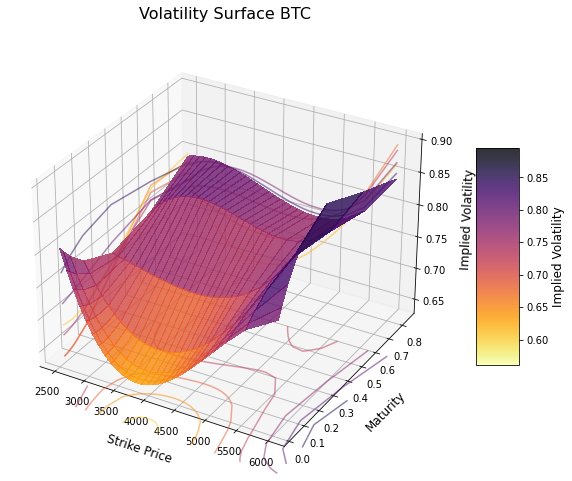

In [66]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize
import numpy as np

# Assuming 'X', 'Y', and 'Z' are your grid and values matrices for plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalize the Z values for color mapping
norm = Normalize(vmin=np.min(Z), vmax=np.max(Z))

# Using a reversed colormap where higher values are darker
cmap = cm.inferno_r

# Plot the surface with the reversed colormap
surf = ax.plot_surface(X, Y, Z_BS, cmap=cmap, linewidth=0, antialiased=False, alpha=0.8, norm=norm)
ax.set_xlabel('Strike Price', fontsize=12, labelpad=10)
ax.set_ylabel('Maturity', fontsize=12, labelpad=10)
ax.set_zlabel('Implied Volatility', fontsize=12, labelpad=10)
ax.set_title('Volatility Surface BTC', fontsize=16, pad=20)

# Add contour lines for better visualization
ax.contour(X, Y, Z_BS, zdir='z', offset=Z.min(), cmap=cmap, linestyles="solid", alpha=0.5)
ax.contour(X, Y, Z_BS, zdir='x', offset=X.min(), cmap=cmap, linestyles="solid", alpha=0.5)
ax.contour(X, Y, Z_BS, zdir='y', offset=Y.max(), cmap=cmap, linestyles="solid", alpha=0.5)

# Adding a color bar which maps values to colors
cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
cbar.set_label('Implied Volatility', fontsize=12)

# Save the plot to a file
fig.savefig('C:/Users/wangd/OneDrive - Università Commerciale Luigi Bocconi/Desktop/Data/BTCvolatility_surface.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()


In [67]:
# Set pandas option to avoid scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df = df[['option_type','index_price','mark_iv','year_fraction','strike','maturity','rf_rate','price']]
df

,option_type,index_price,mark_iv,year_fraction,strike,maturity,rf_rate,price
118,call,3727.53000,0.73650,0.02740,2600.00000,2024-06-07 08:00:00,0.05543,1149.94301
119,put,3727.53000,0.73680,0.02740,2600.00000,2024-06-07 08:00:00,0.05543,0.74551
120,call,3727.49000,0.73630,0.02740,2700.00000,2024-06-07 08:00:00,0.05543,1051.52493
121,put,3727.49000,0.73630,0.02740,2700.00000,2024-06-07 08:00:00,0.05543,1.49100
122,call,3727.49000,0.73650,0.02740,2800.00000,2024-06-07 08:00:00,0.05543,953.86469
...,...,...,...,...,...,...,...,...
484,put,3728.96000,0.74950,0.83288,4800.00000,2025-03-28 08:00:00,0.05238,1648.94611
485,call,3728.96000,0.77330,0.83288,5000.00000,2025-03-28 08:00:00,0.05238,705.51923
486,put,3728.96000,0.77330,0.83288,5000.00000,2025-03-28 08:00:00,0.05238,1828.30909
487,call,3728.97000,0.84270,0.83288,6000.00000,2025-03-28 08:00:00,0.05238,607.44921


## Calibration

### Parameters to determine via calibration with market prices

$\Large \Theta = (v0, \kappa, \theta, \sigma, \rho, \lambda)$

Minimize squared error:



$\Large SqErr(\Theta) = \sum^N_{i=1}\sum^M_{j=1}w_{ij}(C_{MP}(X_i,\tau_j) - C_{SV}(S_\tau, X_i,\tau_j,r_j,\Theta))^2 + Penalty(\Theta, \Theta_0)$

- The penalty function may be e. g. the distance to the initial parameter $vectorPenalty(\Theta, \Theta_0) = ||\Theta − \Theta_0||^2$


### Calibration - Optimization Objective function

$\Large \hat{\Theta} = \underset{\Theta \in U_\Theta}{arg \ min} \ SqErr(\Theta)$

Here we assume that the  set of possible combinations of parameters $U_\Theta$ is compact and in the range for which a solution exists.

In [68]:
def setup_helpers(engine, df, calculation_date, calendar, day_count, yield_ts, dividend_ts):
    heston_helpers = []
    for index, row in df.iterrows():
        maturity_date = ql.Date(row['maturity'].day, row['maturity'].month, row['maturity'].year)
        period = ql.Period(maturity_date - calculation_date, ql.Days)
        helper = ql.HestonModelHelper(period, calendar, row['index_price'], row['strike'], 
                                      ql.QuoteHandle(ql.SimpleQuote(row['mark_iv'])), yield_ts, dividend_ts)
        helper.setPricingEngine(engine)
        heston_helpers.append(helper)
    return heston_helpers

In [69]:
def calibration_report(theta, kappa, sigma, rho, v0, helpers):
    # Output calibrated parameters
    print(f"\nCalibrated Parameters - Theta: {theta}, Kappa: {kappa}, Sigma: {sigma}, Rho: {rho}, V0: {v0}\n")

    mse_sum_error = 0.0
    mae_sum_error = 0.0
    sum_market_price = 0.0
    count = 0

    for helper in helpers:
        model_value = helper.modelValue()
        market_value = helper.marketValue()
        mse_error = (model_value - market_value) ** 2
        mae_error = abs(model_value - market_value)
        mse_error_percent = mse_error / market_value ** 2 * 100
        mae_error_percent = mae_error / market_value * 100

        mse_sum_error += mse_error_percent
        mae_sum_error += mae_error_percent
        sum_market_price += market_value
        count += 1

    # Calculate average errors
    mse_avg_error = mse_sum_error / count
    mae_avg_error = mae_sum_error / count
    arpe_avg_error = (mae_sum_error / sum_market_price) * 100  # Convert to percentage

    print("-" * 100)
    print(f"Average Mean Square Error - MSE (%): {mse_avg_error:.3f}")
    print(f"Average Absolute Percentage Error - MAE (%): {mae_avg_error:.3f}")
    print(f"Average Relative Percentage Error - ARPE (%): {arpe_avg_error:.3f}\n")

    return mse_avg_error, mae_avg_error, arpe_avg_error

In [70]:
# Define the functions
def setup_model(spot, rf_rate, calculation_date, day_count, theta, kappa, sigma, rho, v0):
    
    
    # Create term structures
    yield_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, rf_rate, day_count))
    dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, 0.0, day_count))
    
    # Create the Heston process with the provided term structures and model parameters
    process = ql.HestonProcess(yield_ts, dividend_ts, ql.QuoteHandle(ql.SimpleQuote(spot)), v0, kappa, theta, sigma, rho)
    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model)
    return model, engine, yield_ts, dividend_ts

In [71]:
def quantlib_calibration(init_condition, optimization_algorithm):
    
    # Model parameters
    theta, kappa, sigma, rho, v0 = init_condition

    # Setup the model and engine once using average or representative values
    model, engine, yield_ts, dividend_ts= setup_model(average_spot, average_rf_rate, calculation_date, day_count, theta, kappa, sigma, rho, v0)

    # Setup helpers for all options
    helpers = setup_helpers(engine, df, calculation_date, calendar, day_count, yield_ts, dividend_ts)

    # Calibration
    if optimization_algorithm == 'LevenbergMarquardt':
        optimizer = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
    elif optimization_algorithm == 'Simplex':
        optimizer = ql.Simplex(1.0)
    elif optimization_algorithm == 'BFGS':
        optimizer = ql.BFGS()
    elif optimization_algorithm == 'ConjugateGradient':
        optimizer = ql.ConjugateGradient()
    else:
        print("Choose a optimization algorithm between: LevenbergMarquardt, Simplex, BFGS, and ConjugateGradient")
        return

    model.calibrate(helpers, optimizer, ql.EndCriteria(10000, 1000, 1.0e-8,1.0e-8, 1.0e-8))
    theta, kappa, sigma, rho, v0 = model.params()

    return(theta, kappa, sigma, rho, v0, helpers)
  

## Initial Setup

In [72]:
summary = []
# Initial setup
calculation_date = ql.Date(25, 5, 2024)
ql.Settings.instance().evaluationDate = calculation_date
calendar = ql.NullCalendar()
day_count = ql.Actual365Fixed()

average_spot = df['index_price'].mean()  # Example: use the average or another representative spot price
average_rf_rate = df['rf_rate'].mean()  # Example: use the average or another representative risk-free rate

init_condition = (0.02, 0.2, 0.5, -0.75, 0.01)

## LevenbergMarquardt

Combines the gradient descent and Gauss-Newton methods.

In [73]:
optimization_algorithm = 'LevenbergMarquardt'

theta, kappa, sigma, rho, v0, helpers = quantlib_calibration(init_condition, optimization_algorithm)
mse_avg_error, mae_avg_error, arpe_avg_error = calibration_report(theta, kappa, sigma, rho, v0, helpers)    
summary.append(["QuantLib " + optimization_algorithm, mse_avg_error, mae_avg_error, 
                arpe_avg_error, theta, kappa, sigma, rho, v0])


Calibrated Parameters - Theta: 0.9704493723278269, Kappa: 3.4645524652842723, Sigma: 4.348406499814092, Rho: 0.06925037689626287, V0: 0.37621876682348593

----------------------------------------------------------------------------------------------------
Average Mean Square Error - MSE (%): 1.206
Average Absolute Percentage Error - MAE (%): 8.039
Average Relative Percentage Error - ARPE (%): 2.444



As LevenebergMarquart is a local optimizer we can highlight the fact that it depedns a lot on the initialization

In [49]:
init_condition_2 = (0.9,0.5,0.1,0.9,0.01)


theta, kappa, sigma, rho, v0, helpers = quantlib_calibration(init_condition_2, optimization_algorithm)
mse_avg_error, mae_avg_error, arpe_avg_error = calibration_report(theta, kappa, sigma, rho, v0, helpers)    


Calibrated Parameters - Theta: 1.130621108013594, Kappa: 0.6463216418462676, Sigma: 7.872653248336778e-10, Rho: 0.011020314330130634, V0: 0.0250464106480903

----------------------------------------------------------------------------------------------------
Average Mean Square Error - MSE (%): 56.974
Average Absolute Percentage Error - MAE (%): 72.305
Average Relative Percentage Error - ARPE (%): 1.882



# Simplex
A derivative-free method, useful for noisy functions.

In [22]:
optimization_algorithm = 'Simplex'

theta, kappa, sigma, rho, v0, helpers = quantlib_calibration(init_condition, optimization_algorithm)
mse_avg_error, mae_avg_error, arpe_avg_error = calibration_report(theta, kappa, sigma, rho, v0, helpers)    
summary.append(["QuantLib " + optimization_algorithm, mse_avg_error, mae_avg_error, 
                arpe_avg_error, theta, kappa, sigma, rho, v0])


Calibrated Parameters - Theta: 0.9705073116316606, Kappa: 3.464096587312158, Sigma: 4.348356534441113, Rho: 0.06925021826875637, V0: 0.3762206038874597

----------------------------------------------------------------------------------------------------
Average Mean Square Error - MSE (%): 1.206
Average Absolute Percentage Error - MAE (%): 8.039
Average Relative Percentage Error - ARPE (%): 2.444



## ConjugateGradient
Uses gradients to find the minimum of a function.

In [23]:
optimization_algorithm = 'ConjugateGradient'

theta, kappa, sigma, rho, v0, helpers = quantlib_calibration(init_condition, optimization_algorithm)
mse_avg_error, mae_avg_error, arpe_avg_error = calibration_report(theta, kappa, sigma, rho, v0, helpers)    
summary.append(["QuantLib " + optimization_algorithm, mse_avg_error, mae_avg_error, 
                arpe_avg_error, theta, kappa, sigma, rho, v0])


Calibrated Parameters - Theta: 0.05164223567362081, Kappa: 0.20156024792232888, Sigma: 0.4999419671871811, Rho: -0.7495122671357395, V0: 0.7950276441889672

----------------------------------------------------------------------------------------------------
Average Mean Square Error - MSE (%): 76.219
Average Absolute Percentage Error - MAE (%): 57.704
Average Relative Percentage Error - ARPE (%): 17.541



## BFGS
An iterative method that uses both gradient and approximation to the Hessian;

In [24]:
optimization_algorithm = 'BFGS'

theta, kappa, sigma, rho, v0, helpers = quantlib_calibration(init_condition, optimization_algorithm)
mse_avg_error, mae_avg_error, arpe_avg_error = calibration_report(theta, kappa, sigma, rho, v0, helpers)    
summary.append(["QuantLib " + optimization_algorithm, mse_avg_error, mae_avg_error, 
                arpe_avg_error, theta, kappa, sigma, rho, v0])


Calibrated Parameters - Theta: 0.1733352420820258, Kappa: 1.3583249731467319e-08, Sigma: 0.07475099892242335, Rho: -0.523966727676256, V0: 0.5104872794114984

----------------------------------------------------------------------------------------------------
Average Mean Square Error - MSE (%): 4.153
Average Absolute Percentage Error - MAE (%): 16.186
Average Relative Percentage Error - ARPE (%): 4.920



# Scipy

Using Scipy, we can implement a personalized cost_function to minimize so we will also try to add penalization to have a more robust model

#### Using Scipy Levenberg-Marquardt Solver

In [74]:
def safe_calibration_error(helper):
    try:
        return helper.calibrationError()
    except RuntimeError:
        return np.inf  # Return a large number to signify error without printing

def cost_function_generator(model, helpers, penalty_factor, optimization_algo):
    def cost_function(params):
        try:
            params_ = ql.Array(list(params))
            model.setParams(params_)

            # Collect errors depending on the optimization algorithm
            errors = []
            for helper in helpers:
                error = safe_calibration_error(helper)
                if optimization_algo == 'L-BFGS-B' or optimization_algo == 'differential_evolution' :
                    # Cap the error to avoid overflow issues and use squared errors for scalar optimization
                    error = min(error, 1e6) ** 2
                errors.append(error)

            # Convert errors list to numpy array for efficient computation
            errors = np.array(errors)
            if optimization_algo == 'L-BFGS-B' or optimization_algo == 'differential_evolution':
                # Sum up errors for scalar optimization
                total_error = np.sum(errors)
            else:
                # Return the array of errors for methods expecting multiple residuals
                total_error = errors

            # Apply penalties if applicable
            if penalty_factor is not None:
                penalty = penalty_factor * np.sum(np.square(np.array(params)))
                total_error += penalty

            return total_error
        except Exception as e:
            # Handle any exception by returning a large error
            print("An error occurred: ", e)
            if optimization_algo == 'L-BFGS-B' or optimization_algo == 'differential_evolution':
                return np.inf
            else:
                return np.full(len(params), np.inf)

    return cost_function

In [75]:
def scipy_calibration(init_condition, optimization_algorithm, penalization):
    
    # Model parameters
    theta, kappa, sigma, rho, v0 = init_condition

    # Setup the model and engine once using average or representative values
    model, engine, yield_ts, dividend_ts = setup_model(average_spot, average_rf_rate, calculation_date, day_count, theta, kappa, sigma, rho, v0)

    # Setup helpers for all options
    helpers = setup_helpers(engine, df, calculation_date, calendar, day_count, yield_ts, dividend_ts)
    
    
    if optimization_algorithm == 'lm':
        cost_function = cost_function_generator(model, helpers, penalization, optimization_algorithm)
        result = root(cost_function, init_condition, method=optimization_algorithm)
    elif optimization_algorithm == 'L-BFGS-B':
        cost_function = cost_function_generator(model, helpers, penalization, optimization_algorithm)
        bounds = [(0.001, None), (0.001, None), (0.001, None), (-0.999, 0.999), (0.001, None)] 
        result = minimize(cost_function, init_condition, method=optimization_algorithm, bounds=bounds)
    elif optimization_algorithm == 'differential_evolution':
        cost_function = cost_function_generator(model, helpers, penalization, optimization_algorithm)
        bounds = [(0,1.5),(0.01,15), (0.01,6), (-1,1), (0,1.0) ]
        result = differential_evolution(cost_function, bounds, maxiter=30000)
    else:
        print("Choose a optimization algorithm between: LevenbergMarquardt: 'lm', L-BFGS-B")
        return
        

    if result.success:
        theta, kappa, sigma, rho, v0 = result.x
        print("Calibration successful:")
    else:
        print("Calibration failed:", result.message)
    return(theta, kappa, sigma, rho, v0, helpers)


In [76]:
penalization = 0.005
init_condition = (0.02, 0.2, 0.5, -0.75, 0.01)

## LevenbergMarquardt with Scipy


In [42]:
optimization_algorithm = 'lm'
theta, kappa, sigma, rho, v0, helpers = scipy_calibration(init_condition, optimization_algorithm, penalization)
mse_avg_error, mae_avg_error, arpe_avg_error = calibration_report(theta, kappa, sigma, rho, v0, helpers)    
summary.append(["Scipy LevenbergMarquardt", mse_avg_error, mae_avg_error, 
                arpe_avg_error, theta, kappa, sigma, rho, v0])

Calibration successful:

Calibrated Parameters - Theta: 1.172340690739676, Kappa: 1.1134700112388913, Sigma: 1.681085869925139, Rho: -0.012691965239766966, V0: 0.24045613505196403

----------------------------------------------------------------------------------------------------
Average Mean Square Error - MSE (%): 0.867
Average Absolute Percentage Error - MAE (%): 5.957
Average Relative Percentage Error - ARPE (%): 0.155



## L-BFGS with Scipy

In [54]:
optimization_algorithm = 'L-BFGS-B'
theta, kappa, sigma, rho, v0, helpers = scipy_calibration(init_condition, optimization_algorithm, penalization)
mse_avg_error, mae_avg_error, arpe_avg_error = calibration_report(theta, kappa, sigma, rho, v0, helpers)    
summary.append(["Scipy " + optimization_algorithm, mse_avg_error, mae_avg_error, 
                arpe_avg_error, theta, kappa, sigma, rho, v0])

Calibration successful:

Calibrated Parameters - Theta: 0.7014399392574215, Kappa: 4.406377373977902, Sigma: 3.919383097895125, Rho: 0.09400936306853531, V0: 0.21845884534431628

----------------------------------------------------------------------------------------------------
Average Mean Square Error - MSE (%): 0.402
Average Absolute Percentage Error - MAE (%): 4.069
Average Relative Percentage Error - ARPE (%): 0.106



## Global Optimization - Differential Evolution

In [77]:
from scipy.optimize import differential_evolution

In [78]:
optimization_algorithm = 'differential_evolution'
theta, kappa, sigma, rho, v0, helpers = scipy_calibration(init_condition, optimization_algorithm, penalization)
mse_avg_error, mae_avg_error, arpe_avg_error = calibration_report(theta, kappa, sigma, rho, v0, helpers)    
summary.append(["Scipy " + optimization_algorithm, mse_avg_error, mae_avg_error, 
                arpe_avg_error, theta, kappa, sigma, rho, v0])

Calibration successful:

Calibrated Parameters - Theta: 1.1076388432838973, Kappa: 2.6087665551573638, Sigma: 4.20119568221668, Rho: 0.06677398212255077, V0: 0.3815157707136063

----------------------------------------------------------------------------------------------------
Average Mean Square Error - MSE (%): 1.211
Average Absolute Percentage Error - MAE (%): 8.146
Average Relative Percentage Error - ARPE (%): 2.476



### Summary

In [43]:
result_df = pd.DataFrame(summary,
                      columns=["Method", "MSE (%)", "MAE (%)", "ARPE (%)","Theta (Long Run Variance)", "Kappa (Mean Reversion Rate)", "Sigma (Volatility of variance)", "Rho (Correlation)", "V0 (Initial Variance)"],
                      index=['']*len(summary))
result_df

,Method,MSE (%),MAE (%),ARPE (%),Theta (Long Run Variance),Kappa (Mean Reversion Rate),Sigma (Volatility of variance),Rho (Correlation),V0 (Initial Variance)
,QuantLib LevenbergMarquardt,1.20620,8.03924,2.44384,0.97045,3.46455,4.34841,0.06925,0.37622
,QuantLib Simplex,1.20620,8.03930,2.44385,0.97051,3.46410,4.34836,0.06925,0.37622
,QuantLib ConjugateGradient,76.21939,57.70408,17.54138,0.05164,0.20156,0.49994,-0.74951,0.79503
,QuantLib BFGS,4.15254,16.18555,4.92022,0.17334,0.00000,0.07475,-0.52397,0.51049
,Scipy differential_evolution,1.20620,8.03934,2.44387,0.97049,3.46401,4.34826,0.06925,0.37623
,Scipy differential_evolution,1.20650,8.06550,2.45182,1.00000,3.23635,4.31107,0.06865,0.37759
,Scipy differential_evolution,1.20732,8.06045,2.45028,1.00000,3.18551,4.26107,0.06753,0.37959
,Scipy differential_evolution,1.20620,8.03924,2.44384,0.97042,3.46475,4.34844,0.06925,0.37622
,Scipy differential_evolution,1.20653,8.06672,2.45219,1.00140,3.22688,4.30992,0.06863,0.37763
,Scipy differential_evolution,1.21082,8.14657,2.47647,1.10777,2.60847,4.20140,0.06677,0.38151


In [79]:
import pandas as pd
import QuantLib as ql

def calculate_heston_prices(df, theta, kappa, sigma, rho, v0, calculation_date, calendar, day_count):
    # Create the yield and dividend term structures
    yield_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, df['rf_rate'].iloc[0], day_count))
    dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, 0.0, day_count))
    
    # Create the Heston process and model
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(df['index_price'].iloc[0]))
    heston_process = ql.HestonProcess(yield_ts, dividend_ts, spot_handle, v0, kappa, theta, sigma, rho)
    heston_model = ql.HestonModel(heston_process)
    engine = ql.AnalyticHestonEngine(heston_model)

    # Calculate the prices
    prices = []
    for index, row in df.iterrows():
        maturity_date = ql.Date(row['maturity'].day, row['maturity'].month, row['maturity'].year)
        strike = row['strike']
        option_type = ql.Option.Call if row['option_type'] == 'call' else ql.Option.Put
        payoff = ql.PlainVanillaPayoff(option_type, strike)
        exercise = ql.EuropeanExercise(maturity_date)
        option = ql.VanillaOption(payoff, exercise)
        option.setPricingEngine(engine)
        price = option.NPV()
        prices.append(price)

    # Store prices in the DataFrame and return
    df['heston_price'] = prices
    return df

# Hypothetical market data and options DataFrame
# df should be loaded with your options data, including columns 'maturity', 'strike', 'index_price', 'rf_rate', 'option_type'

# Setup QuantLib dates and conventions
calculation_date = ql.Date.todaysDate()
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
day_count = ql.Actual365Fixed()

# Calculate Heston prices
heston_prices_df = calculate_heston_prices(df, theta, kappa, sigma, rho, v0, calculation_date, calendar, day_count)
heston_prices_df

C:\Users\wangd\AppData\Local\Temp\ipykernel_25288\3025287594.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['heston_price'] = prices


,option_type,index_price,mark_iv,year_fraction,strike,maturity,rf_rate,price,heston_price
118,call,3727.53000,0.73650,0.02740,2600.00000,2024-06-07 08:00:00,0.05543,1149.94301,1132.24854
119,put,3727.53000,0.73680,0.02740,2600.00000,2024-06-07 08:00:00,0.05543,0.74551,0.37880
120,call,3727.49000,0.73630,0.02740,2700.00000,2024-06-07 08:00:00,0.05543,1051.52493,1032.80476
121,put,3727.49000,0.73630,0.02740,2700.00000,2024-06-07 08:00:00,0.05543,1.49100,0.76810
122,call,3727.49000,0.73650,0.02740,2800.00000,2024-06-07 08:00:00,0.05543,953.86469,933.70467
...,...,...,...,...,...,...,...,...,...
484,put,3728.96000,0.74950,0.83288,4800.00000,2025-03-28 08:00:00,0.05238,1648.94611,1665.02036
485,call,3728.96000,0.77330,0.83288,5000.00000,2025-03-28 08:00:00,0.05238,705.51923,768.36566
486,put,3728.96000,0.77330,0.83288,5000.00000,2025-03-28 08:00:00,0.05238,1828.30909,1814.52196
487,call,3728.97000,0.84270,0.83288,6000.00000,2025-03-28 08:00:00,0.05238,607.44921,608.25238


In [80]:
import QuantLib as ql

def calculate_implied_volatilities(df):
    # Prepare to store the results
    implied_vols = []

    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        # Extract option parameters
        spot_price = row['index_price']
        strike_price = row['strike']
        maturity_date = ql.Date(row['maturity'].day, row['maturity'].month, row['maturity'].year)
        risk_free_rate = row['rf_rate']
        heston_price = row['heston_price']
        option_type = ql.Option.Call if row['option_type'].lower() == 'call' else ql.Option.Put

        # Setup the Black-Scholes-Merton process
        calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
        day_count = ql.Actual365Fixed()
        calculation_date = ql.Date.todaysDate()
        ql.Settings.instance().evaluationDate = calculation_date

        dividend_yield = 0.0
        volatility = 0.3  # initial guess
        flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, risk_free_rate, day_count))
        dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, dividend_yield, day_count))
        flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, volatility, day_count))
        bsm_process = ql.BlackScholesMertonProcess(ql.QuoteHandle(ql.SimpleQuote(spot_price)), dividend_ts, flat_ts, flat_vol_ts)

        # Define the payoff and European option
        payoff = ql.PlainVanillaPayoff(option_type, strike_price)
        exercise = ql.EuropeanExercise(maturity_date)
        european_option = ql.VanillaOption(payoff, exercise)
        european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))

        # Calculate implied volatility
        try:
            implied_vol = european_option.impliedVolatility(heston_price, bsm_process)
            implied_vols.append(implied_vol)
        except RuntimeError as e:
            print("Failed to compute implied volatility for row index", index, "with error:", e)
            implied_vols.append(None)

    # Store the results in the DataFrame
    df['implied_vol'] = implied_vols
    return df

# Example of usage
heston_iv = calculate_implied_volatilities(heston_prices_df)
heston_iv

C:\Users\wangd\AppData\Local\Temp\ipykernel_25288\2554007578.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['implied_vol'] = implied_vols


,option_type,index_price,mark_iv,year_fraction,strike,maturity,rf_rate,price,heston_price,implied_vol
118,call,3727.53000,0.73650,0.02740,2600.00000,2024-06-07 08:00:00,0.05543,1149.94301,1132.24854,0.76037
119,put,3727.53000,0.73680,0.02740,2600.00000,2024-06-07 08:00:00,0.05543,0.74551,0.37880,0.76037
120,call,3727.49000,0.73630,0.02740,2700.00000,2024-06-07 08:00:00,0.05543,1051.52493,1032.80476,0.74540
121,put,3727.49000,0.73630,0.02740,2700.00000,2024-06-07 08:00:00,0.05543,1.49100,0.76810,0.74111
122,call,3727.49000,0.73650,0.02740,2800.00000,2024-06-07 08:00:00,0.05543,953.86469,933.70467,0.72478
...,...,...,...,...,...,...,...,...,...,...
484,put,3728.96000,0.74950,0.83288,4800.00000,2025-03-28 08:00:00,0.05238,1648.94611,1665.02036,0.79919
485,call,3728.96000,0.77330,0.83288,5000.00000,2025-03-28 08:00:00,0.05238,705.51923,768.36566,0.81125
486,put,3728.96000,0.77330,0.83288,5000.00000,2025-03-28 08:00:00,0.05238,1828.30909,1814.52196,0.80336
487,call,3728.97000,0.84270,0.83288,6000.00000,2025-03-28 08:00:00,0.05238,607.44921,608.25238,0.83672


In [81]:
import pandas as pd
import numpy as np

# Assuming 'df' is your DataFrame
heston_volatility_surface = heston_iv.pivot_table(
    index='year_fraction',  # Maturity as index
    columns='strike',  # Strike price as columns
    values='implied_vol',  # Volatility as values
    aggfunc=np.mean  # Aggregation function, taking mean if multiple values exist
)

# Convert index and columns to numeric if they're not already
heston_volatility_surface.index = pd.to_numeric(heston_volatility_surface.index, errors='coerce')
heston_volatility_surface.columns = pd.to_numeric(heston_volatility_surface.columns, errors='coerce')

# Fill missing values at the boundaries
heston_volatility_surface.iloc[0].fillna(method='bfill', inplace=True)  # Forward fill the first row
heston_volatility_surface.iloc[-1].fillna(method='ffill', inplace=True)  # Backward fill the last row
heston_volatility_surface.fillna(method='ffill', axis=0, inplace=True)  # Forward fill remaining missing values down columns
heston_volatility_surface.fillna(method='ffill', axis=1, inplace=True)  # Forward fill remaining missing values across rows

# Apply cubic interpolation after initial filling
heston_volatility_surface.interpolate(method='cubic', axis=0, inplace=True)  # Interpolate along maturity
heston_volatility_surface.interpolate(method='cubic', axis=1, inplace=True)  # Interpolate along strike

heston_volatility_surface


strike,2500.00000,2600.00000,2700.00000,2800.00000,2900.00000,3000.00000,3100.00000,3200.00000,3300.00000,3400.00000,3500.00000,3600.00000,3700.00000,3800.00000,3900.00000,4000.00000,4100.00000,4200.00000,4300.00000,4400.00000,4500.00000,4600.00000,4800.00000,5000.00000,5200.00000,5500.00000,6000.00000
year_fraction,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.02740,0.76037,0.76037,0.74326,0.72354,0.70465,0.68721,0.66969,0.65333,0.63901,0.62602,0.61677,0.61008,0.60891,0.61266,0.62023,0.63118,0.64251,0.65543,0.66855,0.68157,0.69434,0.70669,0.73404,0.75739,0.75739,0.75739,0.75739
0.04658,0.76037,0.76037,0.74326,0.72354,0.70465,0.68721,0.66969,0.65254,0.63771,0.62602,0.61677,0.60837,0.60891,0.61232,0.61842,0.62905,0.64059,0.65543,0.66610,0.68157,0.69434,0.70669,0.73404,0.75275,0.75275,0.75275,0.75275
0.08493,0.76750,0.74915,0.73089,0.71234,0.69637,0.67920,0.66359,0.64923,0.63663,0.62625,0.61869,0.61434,0.61352,0.61614,0.62176,0.62975,0.63949,0.65048,0.66610,0.67379,0.68591,0.69787,0.72092,0.74315,0.74315,0.74315,0.83880
0.16164,0.76750,0.73971,0.72384,0.70875,0.69457,0.68134,0.66930,0.65869,0.64980,0.64285,0.63799,0.63535,0.63500,0.63675,0.64042,0.64567,0.65166,0.66001,0.66610,0.67738,0.68591,0.69619,0.71457,0.73461,0.73461,0.77987,0.82071
0.33425,0.76155,0.74983,0.73897,0.72899,0.72010,0.71220,0.70517,0.69972,0.69511,0.69172,0.68945,0.68831,0.68826,0.68898,0.69092,0.69354,0.69686,0.70079,0.70525,0.71013,0.71538,0.72088,0.73249,0.74459,0.74459,0.77987,0.80520
0.58356,0.78730,0.78020,0.77473,0.76829,0.76339,0.75917,0.75565,0.75279,0.75057,0.74898,0.74794,0.74747,0.74747,0.74798,0.74892,0.75026,0.75196,0.75399,0.75631,0.75887,0.76163,0.76460,0.77100,0.77788,0.78511,0.77987,0.81530
0.83288,0.81395,0.80641,0.80641,0.79866,0.79866,0.79583,0.79583,0.79189,0.79053,0.78960,0.78897,0.78869,0.78870,0.78900,0.78900,0.79035,0.79035,0.79257,0.79257,0.79551,0.80077,0.79900,0.80298,0.80730,0.80730,0.80730,0.83178


In [82]:
from scipy.interpolate import SmoothBivariateSpline

# Prepare data
x = heston_volatility_surface.columns.values
y = heston_volatility_surface.index.values
X, Y = np.meshgrid(x, y)
Z = heston_volatility_surface.values

# Create and apply Bivariate Spline
spline = SmoothBivariateSpline(X.ravel(), Y.ravel(), Z.ravel(), s=0.5)  # `s` is a smoothing factor
Z_Heston = spline.ev(X, Y)


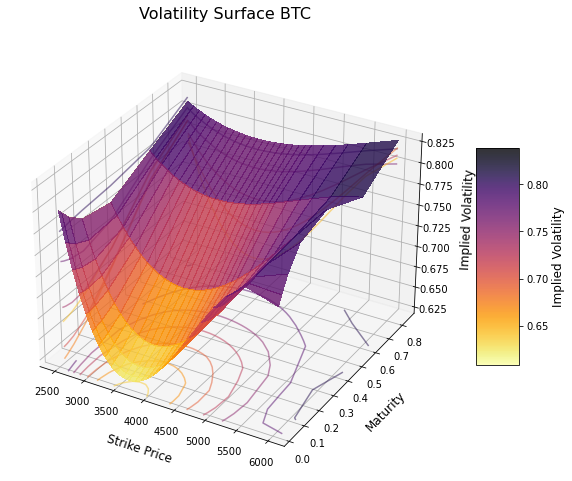

In [83]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize
import numpy as np

# Assuming 'X', 'Y', and 'Z' are your grid and values matrices for plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalize the Z values for color mapping
norm = Normalize(vmin=np.min(Z), vmax=np.max(Z))

# Using a reversed colormap where higher values are darker
cmap = cm.inferno_r

# Plot the surface with the reversed colormap
surf = ax.plot_surface(X, Y, Z_Heston, cmap=cmap, linewidth=0, antialiased=False, alpha=0.8, norm=norm)
ax.set_xlabel('Strike Price', fontsize=12, labelpad=10)
ax.set_ylabel('Maturity', fontsize=12, labelpad=10)
ax.set_zlabel('Implied Volatility', fontsize=12, labelpad=10)
ax.set_title('Volatility Surface BTC', fontsize=16, pad=20)

# Add contour lines for better visualization
ax.contour(X, Y, Z_Heston, zdir='z', offset=Z.min(), cmap=cmap, linestyles="solid", alpha=0.5)
ax.contour(X, Y, Z_Heston, zdir='x', offset=X.min(), cmap=cmap, linestyles="solid", alpha=0.5)
ax.contour(X, Y, Z_Heston, zdir='y', offset=Y.max(), cmap=cmap, linestyles="solid", alpha=0.5)

# Adding a color bar which maps values to colors
cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
cbar.set_label('Implied Volatility', fontsize=12)

# Save the plot to a file
fig.savefig('C:/Users/wangd/OneDrive - Università Commerciale Luigi Bocconi/Desktop/Data/BTCHeston_volatility_surface.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()


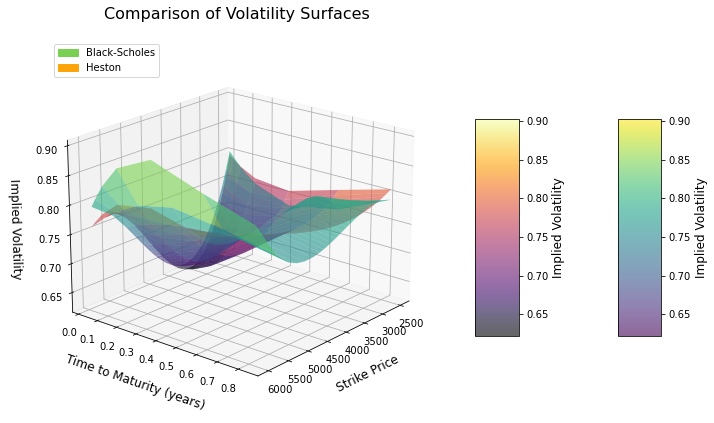

In [84]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize
import numpy as np
import matplotlib.patches as mpatches


# Sample data generation (replace these with your actual data)
# X, Y = np.meshgrid(np.linspace(0, 100, 100), np.linspace(0, 1, 100))
# Z_BS = np.sin(X) * np.cos(Y)  # hypothetical surface data
# Z_Heston = np.sin(X) * np.cos(Y) + 0.1  # hypothetical surface data

# Create the plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalization for consistent color mapping
norm = Normalize(vmin=min(np.min(Z_BS), np.min(Z_Heston)), vmax=max(np.max(Z_BS), np.max(Z_Heston)))

# Plot the Black-Scholes surface
surf_bs = ax.plot_surface(X, Y, Z_BS, cmap=cm.viridis, linewidth=0, antialiased=True, alpha=0.6, label='Black-Scholes', norm=norm)

# Plot the Heston surface
surf_heston = ax.plot_surface(X, Y, Z_Heston, cmap=cm.inferno, linewidth=0, antialiased=True, alpha=0.6, label='Heston', norm=norm)

# Adjust the view angle for a lateral perspective
ax.view_init(elev=20, azim=40)  # Adjust elevation and azimuth for better lateral view

# Labels and title
ax.set_xlabel('Strike Price', fontsize=12, labelpad=10)
ax.set_ylabel('Time to Maturity (years)', fontsize=12, labelpad=10)
ax.set_zlabel('Implied Volatility', fontsize=12, labelpad=10)
ax.set_title('Comparison of Volatility Surfaces', fontsize=16, pad=20)

# Color bar
cbar = fig.colorbar(surf_bs, shrink=0.5, aspect=5, pad=0.1)
cbar.set_label('Implied Volatility', fontsize=12)
cbar2 = fig.colorbar(surf_heston, shrink=0.5, aspect=5, pad=0.1)
cbar2.set_label('Implied Volatility', fontsize=12)

# Create a legend
legend_patch_bs = mpatches.Patch(color=cm.viridis(0.8), label='Black-Scholes')
legend_patch_heston = mpatches.Patch(color=cm.inferno(0.8), label='Heston')
ax.legend(handles=[legend_patch_bs, legend_patch_heston], loc='upper left')


# Save the plot to a file
fig.savefig('C:/Users/wangd/OneDrive - Università Commerciale Luigi Bocconi/Desktop/Data/Vol_surface_fit3.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()



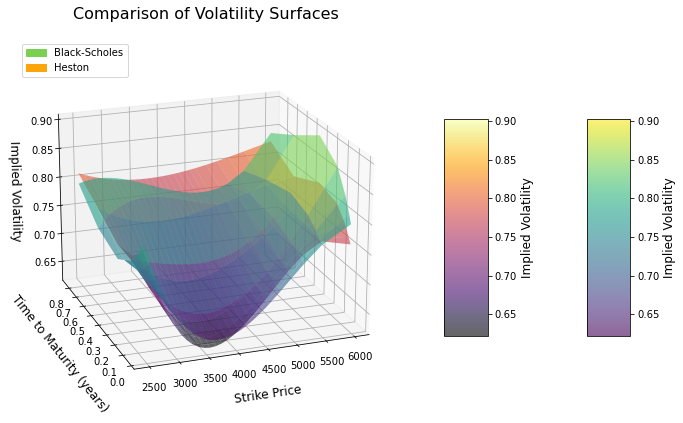

In [85]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize
import numpy as np
import matplotlib.patches as mpatches

# Sample data generation (replace these with your actual data)
# X, Y = np.meshgrid(np.linspace(0, 100, 100), np.linspace(0, 1, 100))
# Z_BS = np.sin(X) * np.cos(Y)  # hypothetical surface data
# Z_Heston = np.sin(X) * np.cos(Y) + 0.1  # hypothetical surface data

# Create the plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalization for consistent color mapping
norm = Normalize(vmin=min(np.min(Z_BS), np.min(Z_Heston)), vmax=max(np.max(Z_BS), np.max(Z_Heston)))

# Plot the Black-Scholes surface
surf_bs = ax.plot_surface(X, Y, Z_BS, cmap=cm.viridis, linewidth=0, antialiased=True, alpha=0.6, label='Black-Scholes', norm=norm)

# Plot the Heston surface
surf_heston = ax.plot_surface(X, Y, Z_Heston, cmap=cm.inferno, linewidth=0, antialiased=True, alpha=0.6, label='Heston', norm=norm)

# Adjust the view angle for a lateral perspective
ax.view_init(elev=20, azim=-110)  # Adjust elevation and azimuth for better lateral view

# Labels and title
ax.set_xlabel('Strike Price', fontsize=12, labelpad=10)
ax.set_ylabel('Time to Maturity (years)', fontsize=12, labelpad=10)
ax.set_zlabel('Implied Volatility', fontsize=12, labelpad=10)
ax.set_title('Comparison of Volatility Surfaces', fontsize=16, pad=20)

# Color bar
cbar = fig.colorbar(surf_bs, shrink=0.5, aspect=5, pad=0.1)
cbar.set_label('Implied Volatility', fontsize=12)
cbar2 = fig.colorbar(surf_heston, shrink=0.5, aspect=5, pad=0.1)
cbar2.set_label('Implied Volatility', fontsize=12)

# Create a legend
legend_patch_bs = mpatches.Patch(color=cm.viridis(0.8), label='Black-Scholes')
legend_patch_heston = mpatches.Patch(color=cm.inferno(0.8), label='Heston')
ax.legend(handles=[legend_patch_bs, legend_patch_heston], loc='upper left')

# Save the plot to a file
fig.savefig('C:/Users/wangd/OneDrive - Università Commerciale Luigi Bocconi/Desktop/Data/Vol_surface_fit4.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()



In [86]:
import numpy as np

# Assuming Z_BS and Z_Heston are your arrays from the code provided above

# Find the maximum difference across the entire grid
diff_surfaces = np.abs(Z_BS - Z_Heston)

max_difference = np.max(diff_surfaces)

min_difference = np.min(diff_surfaces)

mean = np.mean(diff_surfaces)


print(f"The average variation between the Black-Scholes and Heston surfaces is: {mean}")
print(f"The maximum variation between the Black-Scholes and Heston surfaces at any point is: {max_difference}")
print(f"The minimum variation between the Black-Scholes and Heston surfaces at any point is: {min_difference}")


The average variation between the Black-Scholes and Heston surfaces is: 0.015780509174962168
The maximum variation between the Black-Scholes and Heston surfaces at any point is: 0.07972046135094579
The minimum variation between the Black-Scholes and Heston surfaces at any point is: 0.00039068758229032774


In [53]:
BTC
#The average variation between the Black-Scholes and Heston surfaces is: 0.014051372718510943
#The maximum variation between the Black-Scholes and Heston surfaces at any point is: 0.08776812789765387
#The minimum variation between the Black-Scholes and Heston surfaces at any point is: 0.00020159445402379017

NameError: name 'BTC' is not defined

In [ ]:
ETH
#The average variation between the Black-Scholes and Heston surfaces is: 0.015780509174962168
#The maximum variation between the Black-Scholes and Heston surfaces at any point is: 0.07972046135094579
#The minimum variation between the Black-Scholes and Heston surfaces at any point is: 0.00039068758229032774